In [1]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
!pip list

Package                      Version
---------------------------- --------
absl-py                      2.1.0
anyio                        4.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       4.1.0
Brotli                       1.0.9
cachetools                   5.3.3
certifi                      2024.2.2
cffi                         1.16.0
chardet                      5.2.0
charset-normalizer           2.0.4
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.6.7
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.0
execu

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Load data
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = (x_train.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  # Reshape to include channel dimension

In [6]:
print(x_train.shape)

(60000, 28, 28, 1)


In [7]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model



In [8]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

1/1 [==============================] - 5s 5s/step


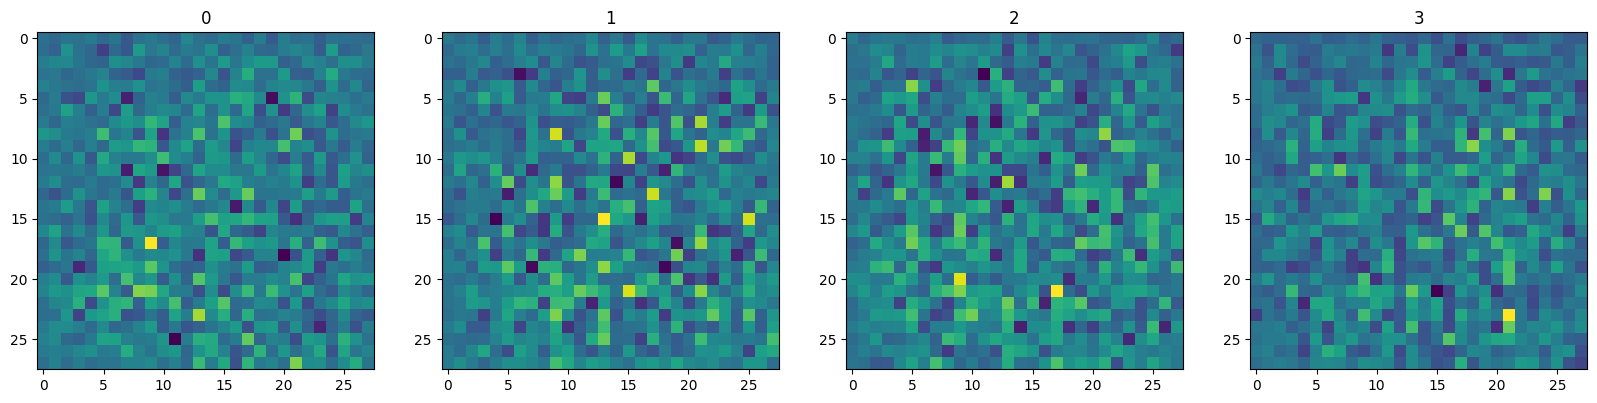

In [9]:
# Generate new fashion
img = generator.predict(np.random.randn(4,100,1))
# Setup the subplot aformatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, sample in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

In [13]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [15]:
# Test discriminator
discriminator.predict(img)

1/1 [==============================] - 0s 310ms/step


array([[-0.00319183],
       [ 0.00061285],
       [-0.00199005],
       [-0.00172115]], dtype=float32)

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [27]:
gen_losses = []
disc_losses = []

In [28]:
# Define the training loop
import os
import time
from IPython.display import clear_output

def train(images, epochs, batch_size):
    for epoch in range(epochs):
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        num_batches = 0
        
        for image_batch in images:
            noise = tf.random.normal([batch_size, 100])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(noise, training=True)

                real_output = discriminator(image_batch, training=True)
                fake_output = discriminator(generated_images, training=True)

                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            num_batches += 1

        avg_gen_loss = epoch_gen_loss / num_batches
        avg_disc_loss = epoch_disc_loss / num_batches
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        print(f"Epoch {epoch+1}, Generator Loss: {avg_gen_loss}, Discriminator Loss: {avg_disc_loss}")

        # Generate and save sample images every 10 epochs
        if (epoch + 1) % 1 == 0:
            clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
            viz(gen_losses, disc_losses)
        if (epoch + 1) % 1000 == 0:
            generator.save("generator.h5")
            discriminator.save("discriminator.h5")

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

In [30]:
# Parameters
BUFFER_SIZE = 60000
BATCH_SIZE = 64  # Reduced batch size
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 4

In [32]:
def viz(gen_losses, disc_losses):
# Plot the generator and discriminator losses
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Losses Over Epochs')
    plt.show()

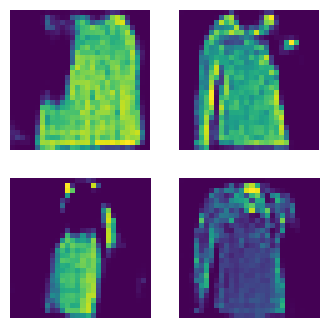

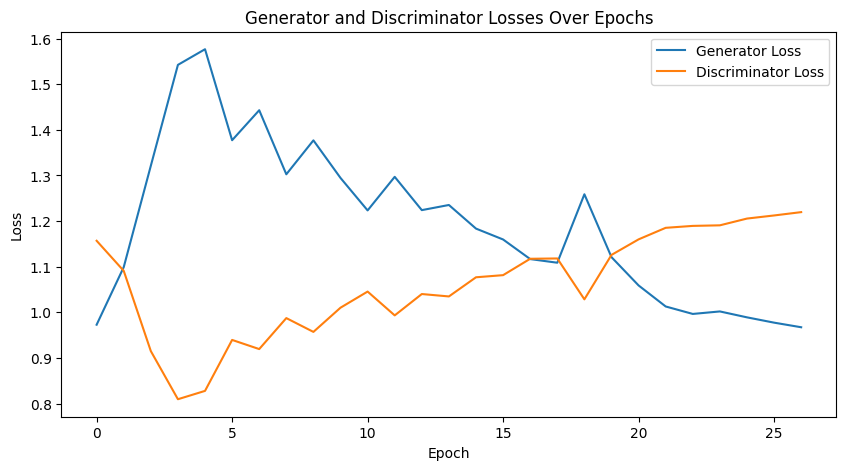

KeyboardInterrupt: 

In [33]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train(train_dataset, EPOCHS, BATCH_SIZE)

In [56]:
# Assuming generator and discriminator are defined and compiled models
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')